In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf, acf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
import cvxopt
import pyreadr
import os
import time
from datetime import timedelta
from scipy.stats import norm
import copy
import warnings
import utils
import regression_fit
import pickle
from importlib import reload
reload(utils)
reload(regression_fit)
from utils import *
from regression_fit import *

home = os.getcwd()

## Dataset preprocessing
Train set: from 2014 to 2018. Test set: from 2019 to 2021

In [4]:
# Import dataset of group C
GroupP = pyreadr.read_r(home + '\\Other_data\\GroupP.rda')
GroupP_df = pd.DataFrame(list(GroupP.values())[0])

# Add autoregressive features (columns y0_96, y0_336, diff_96, diff_336)
GroupP_df = add_autoregressive_features(GroupP_df)

# Split in train and test set 
# 
train_set = GroupP_df[720:87440] 
test_set = GroupP_df[87440:]

### Adding seasonal component to ADF test

In [5]:
from __future__ import annotations

from statsmodels.compat.numpy import lstsq
from statsmodels.compat.pandas import deprecate_kwarg
from statsmodels.compat.python import Literal, lzip
from statsmodels.compat.scipy import _next_regular

from typing import Union, List
import warnings

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
from scipy.signal import correlate

from statsmodels.regression.linear_model import OLS, yule_walker
from statsmodels.tools.sm_exceptions import (
    CollinearityWarning,
    InfeasibleTestError,
    InterpolationWarning,
    MissingDataError,
    ValueWarning,
)
from statsmodels.tools.tools import Bunch, add_constant
from statsmodels.tools.validation import (
    array_like,
    bool_like,
    dict_like,
    float_like,
    int_like,
    string_like,
)
from statsmodels.tsa._bds import bds
from statsmodels.tsa._innovations import innovations_algo, innovations_filter
from statsmodels.tsa.adfvalues import mackinnoncrit, mackinnonp
from statsmodels.tsa.tsatools import add_trend, lagmat, lagmat2ds

ArrayLike1D = Union[np.ndarray, pd.Series, List[float]]

__all__ = [
    "acovf",
    "acf",
    "pacf",
    "pacf_yw",
    "pacf_ols",
    "ccovf",
    "ccf",
    "q_stat",
    "coint",
    "arma_order_select_ic",
    "adfuller",
    "kpss",
    "bds",
    "pacf_burg",
    "innovations_algo",
    "innovations_filter",
    "levinson_durbin_pacf",
    "levinson_durbin",
    "zivot_andrews",
    "range_unit_root_test",
]

SQRTEPS = np.sqrt(np.finfo(np.double).eps)

        
def _autolag(
    mod,
    endog,
    exog,
    startlag,
    maxlag,
    method,
    modargs=(),
    fitargs=(),
    regresults=False,
):
    """
    Returns the results for the lag length that maximizes the info criterion.

    Parameters
    ----------
    mod : Model class
        Model estimator class
    endog : array_like
        nobs array containing endogenous variable
    exog : array_like
        nobs by (startlag + maxlag) array containing lags and possibly other
        variables
    startlag : int
        The first zero-indexed column to hold a lag.  See Notes.
    maxlag : int
        The highest lag order for lag length selection.
    method : {"aic", "bic", "t-stat"}
        aic - Akaike Information Criterion
        bic - Bayes Information Criterion
        t-stat - Based on last lag
    modargs : tuple, optional
        args to pass to model.  See notes.
    fitargs : tuple, optional
        args to pass to fit.  See notes.
    regresults : bool, optional
        Flag indicating to return optional return results

    Returns
    -------
    icbest : float
        Best information criteria.
    bestlag : int
        The lag length that maximizes the information criterion.
    results : dict, optional
        Dictionary containing all estimation results

    Notes
    -----
    Does estimation like mod(endog, exog[:,:i], *modargs).fit(*fitargs)
    where i goes from lagstart to lagstart+maxlag+1.  Therefore, lags are
    assumed to be in contiguous columns from low to high lag length with
    the highest lag in the last column.
    """
    # TODO: can tcol be replaced by maxlag + 2?
    # TODO: This could be changed to laggedRHS and exog keyword arguments if
    #    this will be more general.

    results = {}
    method = method.lower()
    for lag in range(startlag, startlag + maxlag + 1):
        mod_instance = mod(endog, exog[:, :lag], *modargs)
        results[lag] = mod_instance.fit()

    if method == "aic":
        icbest, bestlag = min((v.aic, k) for k, v in results.items())
    elif method == "bic":
        icbest, bestlag = min((v.bic, k) for k, v in results.items())
    elif method == "t-stat":
        # stop = stats.norm.ppf(.95)
        stop = 1.6448536269514722
        # Default values to ensure that always set
        bestlag = startlag + maxlag
        icbest = 0.0
        for lag in range(startlag + maxlag, startlag - 1, -1):
            icbest = np.abs(results[lag].tvalues[-1])
            bestlag = lag
            if np.abs(icbest) >= stop:
                # Break for first lag with a significant t-stat
                break
    else:
        raise ValueError(f"Information Criterion {method} not understood.")

    if not regresults:
        return icbest, bestlag
    else:
        return icbest, bestlag, results

In [6]:
from statsmodels.tools.data import _is_recarray, _is_using_pandas
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tools.validation import (
    array_like,
    bool_like,
    int_like,
    string_like,
)

def add_seasonality(x, freq, prepend=False):
    """
    Add a periodic term to an array.

    Parameters
    ----------
    x : array_like
        Original array of data.
    freq : array of double
        The frequencies for which we add a sin and cos term.

    Returns
    -------
    array_like
        The original data with the additional trend columns.  If x is a
        pandas Series or DataFrame, then the trend column names are 'const',
        'trend' and 'trend_squared'.

    """
    freq = array_like(freq, "freq")
    prepend = bool_like(prepend, "prepend")

    columns = []
    for i, el in enumerate(freq):
        columns.append(f"cos(f{i})")
        columns.append(f"sin(f{i})")

    is_pandas = _is_using_pandas(x, None)
    if is_pandas:
        if isinstance(x, pd.Series):
            x = pd.DataFrame(x)
        else:
            x = x.copy()
    else:
        x = np.asanyarray(x)

    nobs = len(x)
    #trendarr = np.vander(
    #    np.arange(1, nobs + 1, dtype=np.float64), trendorder + 1
    #)
    trend = np.arange(1, nobs + 1, dtype=np.float64)
    seasonarr = np.empty((nobs, 0), dtype=np.float64)
    for f in freq:
        seasonarr = np.c_[seasonarr, np.cos(2*np.pi*f*trend), np.sin(2*np.pi*f*trend)]
   
    order = 1 if prepend else -1
    if is_pandas:
        seasonarr = pd.DataFrame(seasonarr, index=x.index, columns=columns)
        x = [seasonarr, x]
        x = pd.concat(x[::order], axis=1)
    else:
        x = [seasonarr, x]
        x = np.column_stack(x[::order])
    
    return x

In [7]:
def adfullercustom(
    x,
    maxlag: int | None = None,
    regression="c",
    seasonality_freq=None,
    autolag="AIC",
    store=False,
    regresults=False,
):
    """
    Augmented Dickey-Fuller unit root test.

    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.

    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : {None, int}
        Maximum lag which is included in test, default value of
        12*(nobs/100)^{1/4} is used when ``None``.
    regression : {"c","ct","ctt","n"}
        Constant and trend order to include in regression.

        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "n" : no constant, no trend.
        * seasonality : array_like, 1d
        Frequencies to add to the regression for the ADF test

    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
        values 0, 1, ..., maxlag.

        * If "AIC" (default) or "BIC", then the number of lags is chosen
          to minimize the corresponding information criterion.
        * "t-stat" based choice of maxlag.  Starts with maxlag and drops a
          lag until the t-statistic on the last lag length is significant
          using a 5%-sized test.
        * If None, then the number of included lags is set to maxlag.
    store : bool
        If True, then a result instance is returned additionally to
        the adf statistic. Default is False.
    regresults : bool, optional
        If True, the full regression results are returned. Default is False.

    Returns
    -------
    adf : float
        The test statistic.
    pvalue : float
        MacKinnon's approximate p-value based on MacKinnon (1994, 2010).
    usedlag : int
        The number of lags used.
    nobs : int
        The number of observations used for the ADF regression and calculation
        of the critical values.
    critical values : dict
        Critical values for the test statistic at the 1 %, 5 %, and 10 %
        levels. Based on MacKinnon (2010).
    icbest : float
        The maximized information criterion if autolag is not None.
    resstore : ResultStore, optional
        A dummy class with results attached as attributes.

    Notes
    -----
    The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
    root, with the alternative that there is no unit root. If the pvalue is
    above a critical size, then we cannot reject that there is a unit root.

    The p-values are obtained through regression surface approximation from
    MacKinnon 1994, but using the updated 2010 tables. If the p-value is close
    to significant, then the critical values should be used to judge whether
    to reject the null.

    The autolag option and maxlag for it are described in Greene.

    See the notebook `Stationarity and detrending (ADF/KPSS)
    <../examples/notebooks/generated/stationarity_detrending_adf_kpss.html>`__
    for an overview.

    References
    ----------
    .. [1] W. Green.  "Econometric Analysis," 5th ed., Pearson, 2003.

    .. [2] Hamilton, J.D.  "Time Series Analysis".  Princeton, 1994.

    .. [3] MacKinnon, J.G. 1994.  "Approximate asymptotic distribution functions for
        unit-root and cointegration tests.  `Journal of Business and Economic
        Statistics` 12, 167-76.

    .. [4] MacKinnon, J.G. 2010. "Critical Values for Cointegration Tests."  Queen"s
        University, Dept of Economics, Working Papers.  Available at
        http://ideas.repec.org/p/qed/wpaper/1227.html
    """
    x = array_like(x, "x")
    maxlag = int_like(maxlag, "maxlag", optional=True)
    regression = string_like(
        regression, "regression", options=("c", "ct", "ctt", "n")
    )
    autolag = string_like(
        autolag, "autolag", optional=True, options=("aic", "bic", "t-stat")
    )
    #seasonality_freq = array_like(seasonality_freq, "seasonality_freq")
    store = bool_like(store, "store")
    regresults = bool_like(regresults, "regresults")

    if x.max() == x.min():
        raise ValueError("Invalid input, x is constant")

    if regresults:
        store = True

    trenddict = {None: "n", 0: "c", 1: "ct", 2: "ctt"}
    if regression is None or isinstance(regression, int):
        regression = trenddict[regression]
    regression = regression.lower()
    nobs = x.shape[0]

    ntrend = len(regression) if regression != "n" else 0
    if maxlag is None:
        # from Greene referencing Schwert 1989
        maxlag = int(np.ceil(12.0 * np.power(nobs / 100.0, 1 / 4.0)))
        # -1 for the diff
        maxlag = min(nobs // 2 - ntrend - 1, maxlag)
        if maxlag < 0:
            raise ValueError(
                "sample size is too short to use selected "
                "regression component"
            )
    elif maxlag > nobs // 2 - ntrend - 1:
        raise ValueError(
            "maxlag must be less than (nobs/2 - 1 - ntrend) "
            "where n trend is the number of included "
            "deterministic regressors"
        )
    xdiff = np.diff(x)
    xdall = lagmat(xdiff[:, None], maxlag, trim="both", original="in")
    nobs = xdall.shape[0]

    xdall[:, 0] = x[-nobs - 1 : -1]  # replace 0 xdiff with level of x
    xdshort = xdiff[-nobs:]

    if store:
        from statsmodels.stats.diagnostic import ResultsStore

        resstore = ResultsStore()
    if autolag:
        if regression != "n":
            if seasonality_freq is None:
                fullRHS = add_trend(xdall, regression, prepend=True)
            else:
                fullRHS = add_trend(xdall, regression, prepend=True)
                fullRHS = add_seasonality(fullRHS, seasonality_freq, prepend=True)
        else:
            if seasonality_freq is None:
                fullRHS = xdall
            else:
                fullRHS = add_seasonality(xdall, seasonality_freq, prepend=True)
                
        startlag = fullRHS.shape[1] - xdall.shape[1] + 1
        # 1 for level
        # search for lag length with smallest information criteria
        # Note: use the same number of observations to have comparable IC
        # aic and bic: smaller is better

        if not regresults:
            icbest, bestlag = _autolag(
                OLS, xdshort, fullRHS, startlag, maxlag, autolag
            )
        else:
            icbest, bestlag, alres = _autolag(
                OLS,
                xdshort,
                fullRHS,
                startlag,
                maxlag,
                autolag,
                regresults=regresults,
            )
            resstore.autolag_results = alres

        bestlag -= startlag  # convert to lag not column index

        # rerun ols with best autolag
        xdall = lagmat(xdiff[:, None], bestlag, trim="both", original="in")
        nobs = xdall.shape[0]
        xdall[:, 0] = x[-nobs - 1 : -1]  # replace 0 xdiff with level of x
        xdshort = xdiff[-nobs:]
        usedlag = bestlag
    else:
        usedlag = maxlag
        icbest = None
    if regression != "n":
        if seasonality_freq is None:
            resols = OLS(
                xdshort, add_trend(xdall[:, : usedlag + 1], regression)
            ).fit()
        else:
            xd = add_trend(xdall[:, : usedlag + 1], regression)
            resols = OLS(
                xdshort, add_seasonality(xd, seasonality_freq)
            ).fit()
    else:
        if seasonality_freq is None:
            resols = OLS(xdshort, xdall[:, : usedlag + 1]).fit()
        else:
            resols = OLS(
                xdshort, add_seasonality(xdall[:, : usedlag + 1], seasonality_freq)
            ).fit()

    adfstat = resols.tvalues[0]
    #    adfstat = (resols.params[0]-1.0)/resols.bse[0]
    # the "asymptotically correct" z statistic is obtained as
    # nobs/(1-np.sum(resols.params[1:-(trendorder+1)])) (resols.params[0] - 1)
    # I think this is the statistic that is used for series that are integrated
    # for orders higher than I(1), ie., not ADF but cointegration tests.

    # Get approx p-value and critical values
    pvalue = mackinnonp(adfstat, regression=regression, N=1)
    critvalues = mackinnoncrit(N=1, regression=regression, nobs=nobs)
    critvalues = {
        "1%": critvalues[0],
        "5%": critvalues[1],
        "10%": critvalues[2],
    }
    if store:
        resstore.resols = resols
        resstore.maxlag = maxlag
        resstore.usedlag = usedlag
        resstore.adfstat = adfstat
        resstore.critvalues = critvalues
        resstore.nobs = nobs
        resstore.H0 = (
            "The coefficient on the lagged level equals 1 - " "unit root"
        )
        resstore.HA = "The coefficient on the lagged level < 1 - stationary"
        resstore.icbest = icbest
        resstore._str = "Augmented Dickey-Fuller Test Results"
        return adfstat, pvalue, critvalues, resstore
    else:
        if not autolag:
            return adfstat, pvalue, usedlag, nobs, critvalues
        else:
            return adfstat, pvalue, usedlag, nobs, critvalues, icbest


# ADF test

The p-value of the ADF test is printed taking into account around 1y of data. In this case we are not using the constant (regression="n") and we are using 3 different time series: net-load, 7d differenced net-load and 48h differenced net-load

In [16]:
t1 = 0
t2 = 20000

res = adfuller(train_set['node'][t1:t2], regression="n")
print("p-value adf test: ", res[1])

res = adfuller(train_set['diff_336'][t1:t2], regression="n")
print("p-value adf test on 7d differences: ", res[1])

res = adfuller(train_set['diff_96'][t1:t2], regression="n")
print("p-value adf test on 48h differences: ", res[1])

p-value adf test:  6.53490169397994e-12
p-value adf test on 7d differences:  1.5705368479005027e-20
p-value adf test on 48h differences:  1.2273418636128096e-25


The p-value of the ADF test is printed taking into account less than 1y of data. In this case we using the constant (regression="c") and we are using 3 different time series: net-load, 7d differenced net-load and 48h differenced net-load.

The p-value of the net-load time series is already below 5%.

In [17]:
t1 = 0
t2 = 15000

res = adfullercustom(train_set['node'][t1:t2], regression="c", seasonality_freq=None)
print("p-value adf test: ", res[1])

res = adfullercustom(train_set['diff_336'][t1:t2], regression="c", seasonality_freq=None)
print("p-value adf test on 7d differences: ", res[1])

res = adfullercustom(train_set['diff_96'][t1:t2], regression="c", seasonality_freq=None)
print("p-value adf test on 48h differences: ", res[1])

p-value adf test:  1.7933245826762614e-11
p-value adf test on 7d differences:  3.3572207686660717e-25
p-value adf test on 48h differences:  1.0367787739469974e-27


# Modified ADF test

The p-value of the ADF test is printed taking into account less than 1y of data. In this case we using the constant (regression="c") and we are using comparing the p-values of the two tests: the first without considering the periodic component (7d sin + cos) in the test and the second considering the periodic component.

We can observe that the p-value decreases even though it was already below 5%.

In [18]:
t1=0
t2=15000
# Period is intended in terms of number of observations
#freq = 1/np.array([24,48,336]) # we can add multiple periods
freq = 1/np.array([336])
res = adfullercustom(train_set['node'][t1:t2], regression="c", seasonality_freq=None)
print("p-value adf test: ", res[1])
res = adfullercustom(train_set['node'][t1:t2], regression="c", seasonality_freq=freq)
print("p-value adf test with periodic component: ", res[1])

p-value adf test:  1.7933245826762614e-11
p-value adf test with periodic component:  1.6358592698004625e-11


# ADF test for seasonality

p-values of the 336 weekly time series (one for each 30 minutes in 7 days) and of their differenced time series

In [19]:
p_value_336 = []
p_value_336_diff = []
for t in range(336):
    res = adfuller(np.array(train_set['node'])[t::336],regression='c',regresults=True)
    p_value_336.append(res[1])    
    y_336 = np.array(train_set['node'])[t::336]
    y_diff = y_336[1:]-y_336[:-1]
    res = adfuller(y_diff,regression='c',regresults=True)
    p_value_336_diff.append(res[1])


Text(0.5, 1.0, 'p-values of the differenced weekly series')

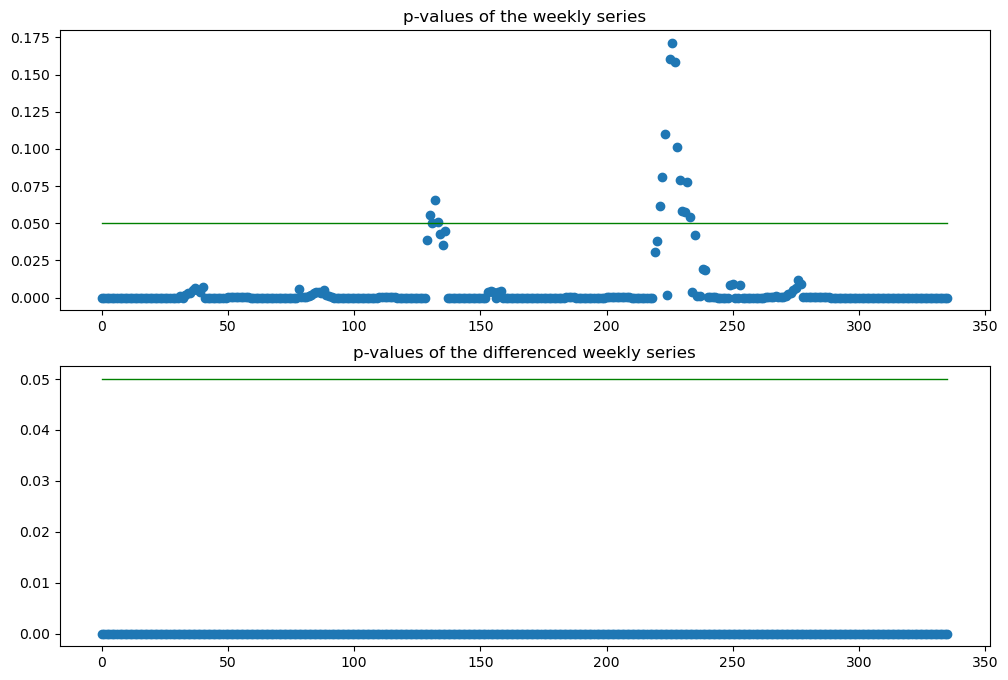

In [20]:
figure, axs = plt.subplots(2,1, figsize=(12,8))
axs[0].plot(p_value_336, 'o')
axs[0].plot(range(336), 0.05*np.ones(336,), color='green', linewidth=1, label='5%')
axs[0].set_title("p-values of the weekly series")
axs[1].plot(p_value_336_diff, 'o')
axs[1].plot(range(336), 0.05*np.ones(336,), color='green', linewidth=1, label='5%')
axs[1].set_title("p-values of the differenced weekly series")

p-values of the 48 daily time series (one for each 30 minutes in 24h) and of their differenced time series

In [21]:
p_value = []
p_value_diff48 = []
for t in range(48):
    res = adfuller(np.array(train_set['node'])[t::48],regression='c',regresults=True)
    p_value.append(res[1])
    
    y_48 = np.array(train_set['node'])[t::48]
    y_diff = y_48[1:]-y_48[:-1]
    res = adfuller(y_diff,regression='c',regresults=True)
    p_value_diff48.append(res[1])
 

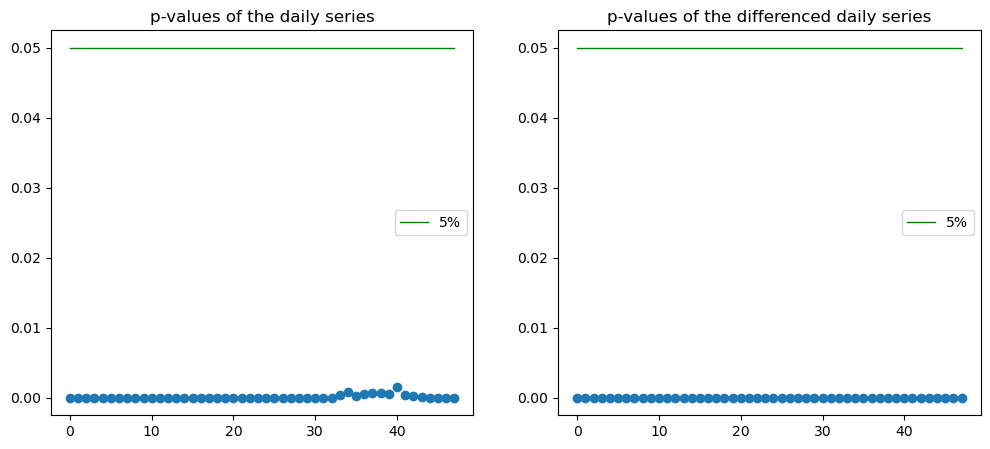

In [22]:
figure, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(p_value, 'o')
axs[0].plot(range(48), 0.05*np.ones(48,), color='green', linewidth=1, label='5%')
axs[0].set_title("p-values of the daily series")
axs[1].plot(p_value_diff48, 'o')
axs[1].plot(range(48), 0.05*np.ones(48,), color='green', linewidth=1, label='5%')
axs[1].set_title("p-values of the differenced daily series")
axs[0].legend()
axs[1].legend()

# Partial Autocorrelation plots of the net-load TS and of the differenced net-load TS 

C:\Users\Utente\AppData\Local\Temp\ipykernel_18048\454205749.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(n_lags+1), pacf(train_set['node'], nlags=n_lags), 'o')


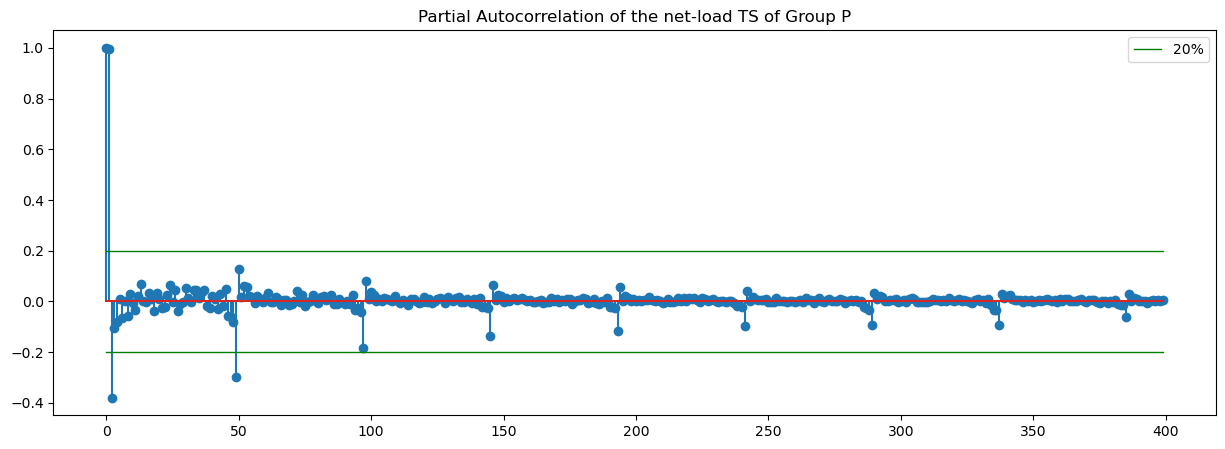

In [23]:
n_lags = 399
fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(n_lags+1), pacf(train_set['node'], nlags=n_lags), 'o')
plt.plot(range(n_lags+1), 0.2*np.ones(n_lags+1,), color='green', linewidth=1, label='20%')
plt.plot(range(n_lags+1), -0.2*np.ones(n_lags+1,), color='green', linewidth=1)
plt.title('Partial Autocorrelation of the net-load TS of Group P');
plt.legend()

C:\Users\Utente\AppData\Local\Temp\ipykernel_18048\3569376281.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(n_lags+1), pacf(train_set['diff_336'], nlags=n_lags), 'o')


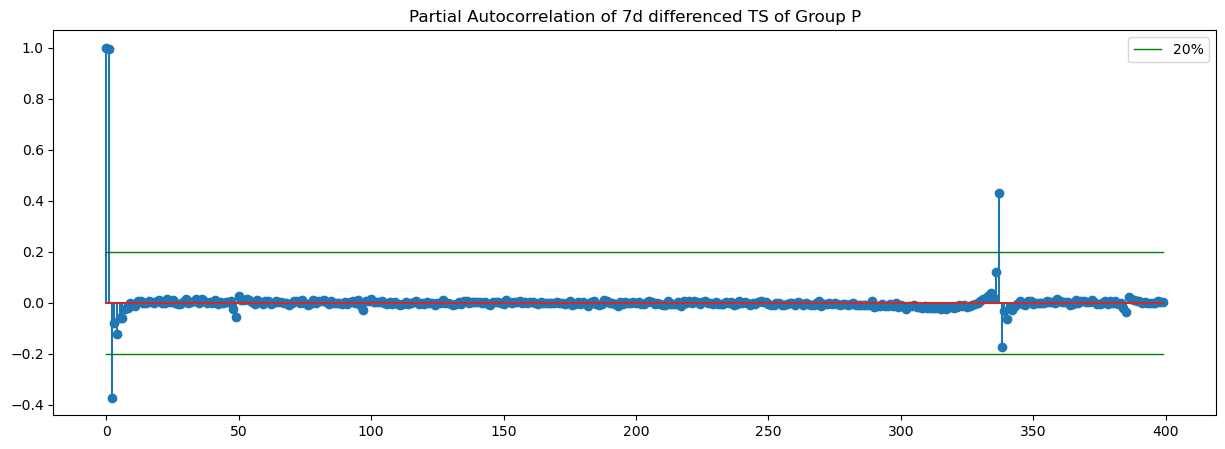

In [24]:
n_lags = 399
fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(n_lags+1), pacf(train_set['diff_336'], nlags=n_lags), 'o')
plt.plot(range(n_lags+1), 0.2*np.ones(n_lags+1,), color='green', linewidth=1, label='20%')
plt.plot(range(n_lags+1), -0.2*np.ones(n_lags+1,), color='green', linewidth=1)
plt.title('Partial Autocorrelation of 7d differenced TS of Group P');
plt.legend()

C:\Users\Utente\AppData\Local\Temp\ipykernel_18048\2342635902.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(train_set['diff_96'], nlags=399), 'o')


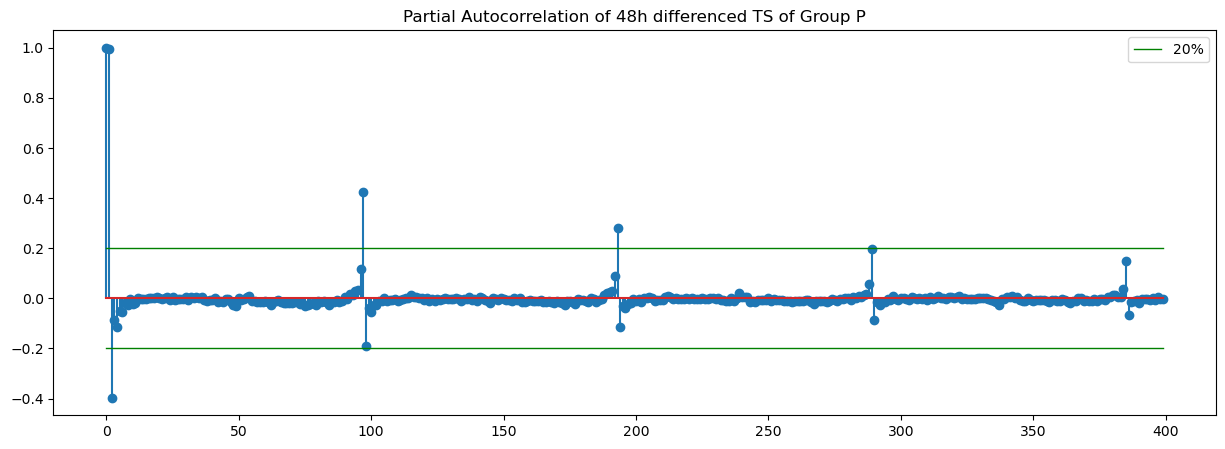

In [25]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(400), pacf(train_set['diff_96'], nlags=399), 'o')
plt.plot(range(400), 0.2*np.ones(400,), color='green', linewidth=1, label='20%')
plt.plot(range(400), -0.2*np.ones(400,), color='green', linewidth=1)
plt.title('Partial Autocorrelation of 48h differenced TS of Group P');
plt.legend()

# Analysis of the distribution of the net-load and the differenced net-load time series

Distribution of the net-load

In [84]:
Rt = train_set['node']
mu_Rt = Rt.mean()
std_Rt = Rt.std()

C:\Users\Utente\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


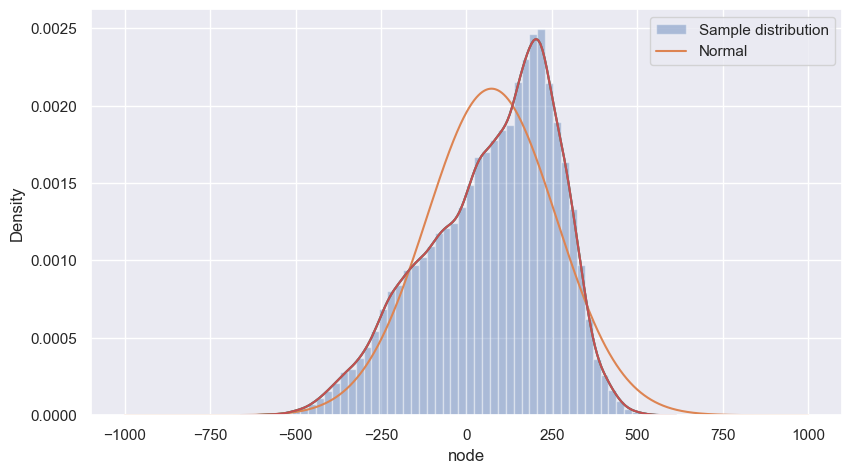

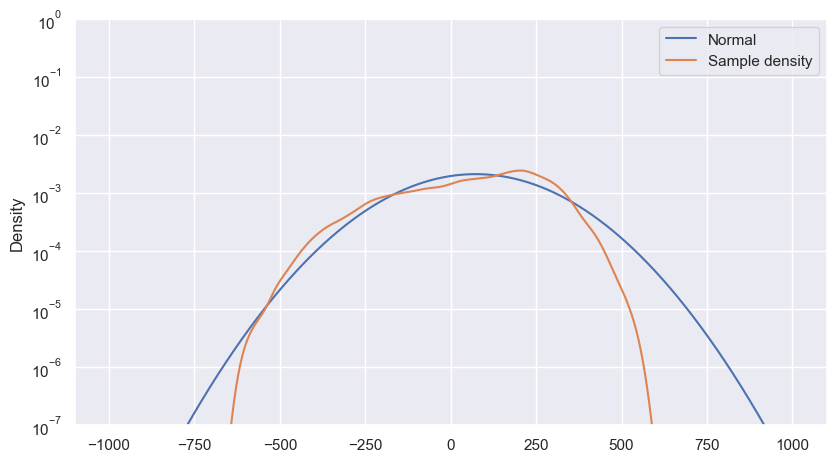

In [85]:
from scipy.stats import norm

x = np.linspace(-1000,1000,10000)

sns.set(rc={'figure.figsize':(9.7,5.27)})
sns.distplot(Rt, label='Sample distribution')
plt.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
plt.legend()

# Density estimation
x_values = sns.kdeplot(Rt).get_lines()[0].get_xdata()
kde_values = sns.kdeplot(Rt).get_lines()[0].get_ydata()

fig, axs = plt.subplots(1,1)
axs.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
axs.plot(x_values, kde_values, label='Sample density')
axs.set_ylabel("Density")
axs.set_ylim([10**-7,1])
axs.set_yscale('log')
axs.legend()


Distribution of the 7d differenced net-load

In [86]:
Rt = train_set['diff_336']
mu_Rt = Rt.mean()
std_Rt = Rt.std()

C:\Users\Utente\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


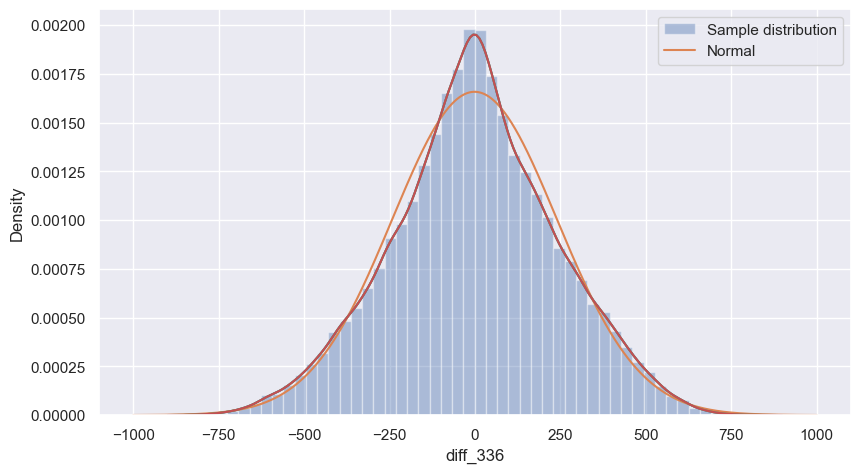

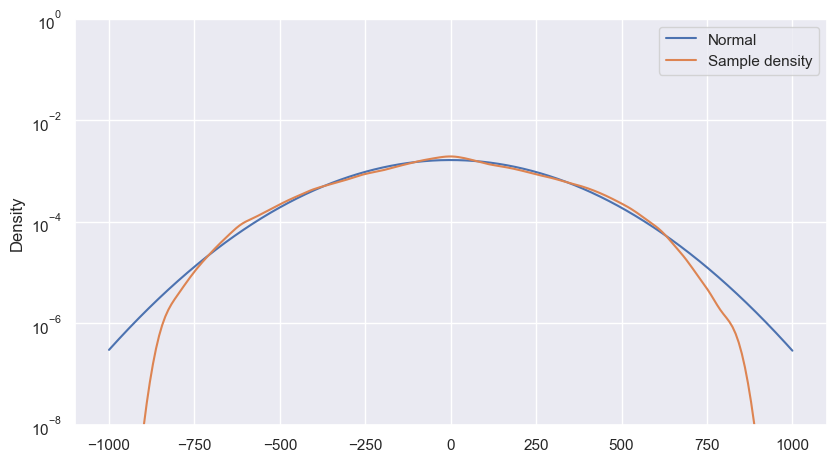

In [87]:
from scipy.stats import norm

x = np.linspace(-1000,1000,10000)

sns.set(rc={'figure.figsize':(9.7,5.27)})
sns.distplot(Rt, label='Sample distribution')
plt.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
plt.legend()

# Density estimation
x_values = sns.kdeplot(Rt).get_lines()[0].get_xdata()
kde_values = sns.kdeplot(Rt).get_lines()[0].get_ydata()

fig, axs = plt.subplots(1,1)
axs.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
axs.plot(x_values, kde_values, label='Sample density')
axs.set_ylabel("Density")
axs.set_ylim([10**-8,1])
axs.set_yscale('log')
axs.legend()


# Dataset Preprocessing for GAM

In [30]:
features = ['t', 't2', 'doy_s', 'doy_c', 'doy_s2', 'doy_c2', 'node_sm', 'clock_hour', 'dow_RpH', 'School_Hol', 
           'x2T_weighted.mean_p_max_point', 'x2Tsm_point', 'SSRD_mean_2_Cap', 'WindSpd100_weighted.mean_cell','EMBEDDED_WIND_CAPACITY',
           'WindSpd10_weighted.mean_cell', 'TP_weighted.mean_cell']
features_to_standardize = ['node_sm','clock_hour','x2T_weighted.mean_p_max_point', 'x2Tsm_point', 'SSRD_mean_2_Cap', 'WindSpd100_weighted.mean_cell','EMBEDDED_WIND_CAPACITY',
                          'WindSpd10_weighted.mean_cell', 'TP_weighted.mean_cell']


def dataset_preprocessing(df, features, features_to_standardize, exog_name):
    df_std = standardize_dataframe(df[features_to_standardize])
    for f in list(set(features) - set(features_to_standardize+['t2'])):
        df_std[f] = df[f]
    df_std['t2'] = df_std['t']**2
    df_std['dow_RpH'] = 1*(df_std['dow_RpH']=='Lun')+2*(df_std['dow_RpH']=='Mar')+\
                            3*(df_std['dow_RpH']=='Mer')+4*(df_std['dow_RpH']=='Jeu')+\
                            5*(df_std['dow_RpH']=='Ven')+6*(df_std['dow_RpH']=='Sam')+\
                            7*(df_std['dow_RpH']=='Dim')+8*(df_std['dow_RpH']=='Autumn Break')+\
                            9*(df_std['dow_RpH']=='Christmas Holiday')+10*(df_std['dow_RpH']=='Easter Holidays')+\
                            11*(df_std['dow_RpH']=='Summer Break')+12*(df_std['dow_RpH']=='Summer Holiday')+\
                            13*(df_std['dow_RpH']=='February Half Term')
    df_std['School_Hol'] = 1*(df_std['School_Hol']=='N')+2*(df_std['School_Hol']=='School Holiday')+\
                            3*(df_std['School_Hol']=='Christmas Holiday')
    target = df[exog_name]
    return np.array(df_std[features]), np.array(target)

# GAM model
Target variable: Net-Load

In [31]:
from pygam import LinearGAM, s, f, l, te

target_var = 'node'

X_train, Y_train = dataset_preprocessing(train_set, features, features_to_standardize, target_var)
X_test, Y_test = dataset_preprocessing(test_set, features, features_to_standardize, target_var)

gam_model = LinearGAM(l(0) + l(1) + l(2) + l(3) + l(4) + l(5) + l(6) + s(7,n_splines=35,basis='cp') + f(8) + f(9) + 
                         te(7,8,n_splines=30,dtype=['numerical','categorical'],basis='cp')+te(7,9,n_splines=20,dtype=['numerical','categorical'],basis='cp')+
                         s(10,n_splines=35,basis='cp')+s(11,n_splines=35,basis='cp')+s(12,n_splines=5,basis='cp')+ 
                         te(13,14,n_splines=20,basis='cp')+l(15)+s(16,n_splines=5,basis='cp')+te(10,7,n_splines=17)+te(16,7,n_splines=17))

gam_model.fit(np.array(X_train), np.array(Y_train))
y_GAM = gam_model.predict(np.array(X_test))

print("RMSE GAM on test set: ", RMSE(np.array(test_set['node']), y_GAM))
print("MAE GAM on test set: ", MAE(np.array(test_set['node']), y_GAM))
print("MAPE GAM on test set: ", MAPE(np.array(test_set['node']), y_GAM))

RMSE GAM on test set:  116.77406903800726
MAE GAM on test set:  91.59408724419778
MAPE GAM on test set:  2.3462464063704203


## Static Kalman Filter

In [32]:
kf_static = Kalman_Filter(gam_model=gam_model)
kf_static.fit(X_train, Y_train)
std_static = np.std(kf_static.theta_mat[1000:],axis=0)

In [33]:
y_Kalman_static, y_Kalman_static_std = kf_static.predict(X_test, Y_test)
y_Kalman_static_delay, y_Kalman_static_std_delay = kf_static.predict(X_test, test_set[["targetTime", "node"]], delay=True)

In [34]:
print("RMSE Static Kalman filter: ", RMSE(test_set['node'], y_Kalman_static))
print("MAE Static Kalman filter: ", MAE(test_set['node'], y_Kalman_static))
print("MAPE Static Kalman filter: ", MAPE(test_set['node'], y_Kalman_static))

print("\nRMSE Static Kalman filter delay: ", RMSE(test_set['node'], y_Kalman_static_delay))
print("MAE Static Kalman filter delay: ", MAE(test_set['node'], y_Kalman_static_delay))
print("MAPE Static Kalman filter delay: ", MAPE(test_set['node'], y_Kalman_static_delay))

RMSE Static Kalman filter:  93.48137610582201
MAE Static Kalman filter:  72.80225672617999
MAPE Static Kalman filter:  1.8846887636082998

RMSE Static Kalman filter delay:  94.25722217569188
MAE Static Kalman filter delay:  73.38907790692927
MAPE Static Kalman filter delay:  1.8953097849875735


## Dynamic Kalman Filter
Here below we compute the predictions obtained with the dynamic Kalman filter by using variances optimized in different ways (Q and sigma)

### Optimized matrix for P (viking package)

In [37]:
with open('DynamicKF_matrices_py/Q_P.npy', 'rb') as f:
    Q = np.load(f)
    sigma = np.load(f)
    #theta = np.load(f)
    #P = np.load(f)
    
kf_dynamic = Kalman_Filter(gam_model=gam_model, Q=Q, sigma=sigma) #, P=P, theta1=theta)
kf_dynamic.fit(X_train, Y_train)

y_Kalman_dynamic, y_Kalman_dynamic_std = kf_dynamic.predict(X_test, Y_test)
y_Kalman_dynamic_delay, y_Kalman_dynamic_delay_std = kf_dynamic.predict(X_test, test_set, delay=True)

### Optimized matrix P (Likelihood maximization)

In this case we assume Q=q*I_d

In [40]:
q_list = [1e-10,1e-11, 1e-12,1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18]

optim = Q_optimization(X_train, train_set[["targetTime", "node"]], GAM=True, gam_model=gam_model)

Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list)  #std_static=std_static)

1e-10
-370573.54770558665
1e-11
-369881.8555694651
1e-12
-370131.56159419625
1e-13
-370483.30216420576
1e-14
-370632.2577254689
1e-15
-370656.1418560835
1e-16
-370658.6974207119
1e-17
-370658.9547992198
1e-18
-370658.9805546678
Optimal values q and sigma:  4.923578230281381e-08 70.16821381709372


In [41]:
kf_dynamic = Kalman_Filter(gam_model=gam_model, Q=Q, sigma=sigma, P=P, theta1=theta1)
kf_dynamic.fit(X_train, Y_train)

y_Kalman_dynamic_delay_red_lik, _ = kf_dynamic.predict(X_test, test_set, delay=True)

### Optimized matrix P (Likelihood maximization)

In this case we assume Q=q*I_d and we optimize theta_1|0

In [42]:
q_list = [1e-10,1e-11, 1e-12,1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18]

optim = Q_optimization(X_train, train_set[["targetTime", "node"]], GAM=True, gam_model=gam_model)

Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list, fit_theta1=True)  

1e-10
-395119.91121853294
1e-11
-389803.7151717623
1e-12
-386702.0746209897
1e-13
-386376.4847416285
1e-14
-386420.53737047565
1e-15
-386431.347019349
1e-16
-386432.54724580364
1e-17
-386432.668558296
1e-18
-386432.6807206068
Optimal values q and sigma:  7.212622544152095e-10 84.92716022658531


In [43]:
kf_dynamic = Kalman_Filter(gam_model=gam_model, Q=Q, sigma=sigma, P=P, theta1=theta1)
kf_dynamic.fit(X_train, Y_train)

y_Kalman_dynamic_delay_red_lik_theta1, _ = kf_dynamic.predict(X_test, test_set, delay=True)

### Optimized matrix P (Likelihood maximization)

In this case we assume Q=q*np.diag(std_static^2)

In [44]:
q_list = [1e-10,1e-11, 1e-12,1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18]

optim = Q_optimization(X_train, train_set[["targetTime", "node"]], GAM=True, gam_model=gam_model)

Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list,std_static=std_static)

1e-10
-375790.3496416795
1e-11
-372206.3919406488
1e-12
-370759.79819597676
1e-13
-370494.2500764965
1e-14
-370574.8159189096
1e-15
-370638.9170094812
1e-16
-370656.54142486677
1e-17
-370658.7335027492
1e-18
-370658.9583662249
Optimal values q and sigma:  4.998730378383454e-10 70.70169996812986


In [45]:
kf_dynamic = Kalman_Filter(gam_model=gam_model, Q=Q, sigma=sigma, P=P, theta1=theta1)
kf_dynamic.fit(X_train, Y_train)

y_Kalman_dynamic_delay_red_lik_std, _ = kf_dynamic.predict(X_test, test_set, delay=True)

In [46]:
print("Matrix computed with viking")
print("\nRMSE Dynamic Kalman filter delay: ", RMSE(test_set['node'], y_Kalman_dynamic_delay))
print("MAE Dynamic Kalman filter delay: ", MAE(test_set['node'], y_Kalman_dynamic_delay))
print("MAPE Dynamic Kalman filter delay: ", MAPE(test_set['node'], y_Kalman_dynamic_delay))

print("\nMatrix computed with maximizing reduced likelihood with Q=q*I_d")
print("\nRMSE Dynamic Kalman filter delay: ", RMSE(test_set['node'], y_Kalman_dynamic_delay_red_lik))
print("MAE Dynamic Kalman filter delay: ", MAE(test_set['node'], y_Kalman_dynamic_delay_red_lik))
print("MAPE Dynamic Kalman filter delay: ", MAPE(test_set['node'], y_Kalman_dynamic_delay_red_lik))

print("\nMatrix computed with maximizing reduced likelihood with Q=q*I_d and optimizing theta_1|0")
print("\nRMSE Dynamic Kalman filter delay: ", RMSE(test_set['node'], y_Kalman_dynamic_delay_red_lik_theta1))
print("MAE Dynamic Kalman filter delay: ", MAE(test_set['node'], y_Kalman_dynamic_delay_red_lik_theta1))
print("MAPE Dynamic Kalman filter delay: ", MAPE(test_set['node'], y_Kalman_dynamic_delay_red_lik_theta1))

print("\nMatrix computed with maximizing reduced likelihood with Q=q*diag(std_static^2)")
print("\nRMSE Dynamic Kalman filter delay: ", RMSE(test_set['node'], y_Kalman_dynamic_delay_red_lik_std))
print("MAE Dynamic Kalman filter delay: ", MAE(test_set['node'], y_Kalman_dynamic_delay_red_lik_std))
print("MAPE Dynamic Kalman filter delay: ", MAPE(test_set['node'], y_Kalman_dynamic_delay_red_lik_std))

Matrix computed with viking

RMSE Dynamic Kalman filter delay:  139.72059466502967
MAE Dynamic Kalman filter delay:  104.50554643290495
MAPE Dynamic Kalman filter delay:  3.5965497923456997

Matrix computed with maximizing reduced likelihood with Q=q*I_d

RMSE Dynamic Kalman filter delay:  82.3019498637312
MAE Dynamic Kalman filter delay:  63.05583834926424
MAPE Dynamic Kalman filter delay:  1.8891010399088561

Matrix computed with maximizing reduced likelihood with Q=q*I_d and optimizing theta_1|0

RMSE Dynamic Kalman filter delay:  91.02692021440937
MAE Dynamic Kalman filter delay:  70.16652128151665
MAPE Dynamic Kalman filter delay:  1.8747944775005225

Matrix computed with maximizing reduced likelihood with Q=q*diag(std_static^2)

RMSE Dynamic Kalman filter delay:  91.6714424277761
MAE Dynamic Kalman filter delay:  70.63398820397448
MAPE Dynamic Kalman filter delay:  1.9759205829686728


Instead of using the net-load as target variable we use the 7d differenced net-load time series 

# GAM model
Target variable: 7 days Differenced Net-Load

In [47]:
from pygam import LinearGAM, s, f, l, te

target_var = 'diff_336'

X_train, Y_train = dataset_preprocessing(train_set, features, features_to_standardize, target_var)
X_test, Y_test = dataset_preprocessing(test_set, features, features_to_standardize, target_var)

gam_model_diff7d = LinearGAM(l(0) + l(1) + l(2) + l(3) + l(4) + l(5) + l(6) + s(7,n_splines=35,basis='cp') + f(8) + f(9) + 
                         te(7,8,n_splines=30,dtype=['numerical','categorical'],basis='cp')+te(7,9,n_splines=20,dtype=['numerical','categorical'],basis='cp')+
                         s(10,n_splines=35,basis='cp')+s(11,n_splines=35,basis='cp')+s(12,n_splines=5,basis='cp')+ 
                         te(13,14,n_splines=20,basis='cp')+l(15)+s(16,n_splines=5,basis='cp')+te(10,7,n_splines=17)+te(16,7,n_splines=17))

gam_model_diff7d.fit(np.array(X_train), np.array(Y_train))
y_GAM = gam_model_diff7d.predict(np.array(X_test))

# We sum the value of 7 days before to the predicted difference
y_pred = test_set['y0_336'] + y_GAM

print("RMSE GAM 7d differenced net-load: ", RMSE(np.array(test_set['node']), y_pred))
print("MAE GAM 7d differenced net-load: ", MAE(np.array(test_set['node']), y_pred))
print("MAPE GAM 7d differenced net-load: ", MAPE(np.array(test_set['node']), y_pred))

RMSE GAM 7d differenced net-load:  291.62293090187944
MAE GAM 7d differenced net-load:  229.500809695602
MAPE GAM 7d differenced net-load:  7.449046982255928


## Static Kalman Filter

In [48]:
kf_static = Kalman_Filter(gam_model=gam_model_diff7d)
kf_static.fit(X_train, Y_train)
std_static = np.std(kf_static.theta_mat[1000:],axis=0)

In [49]:
y_Kalman_static, y_Kalman_static_std = kf_static.predict(X_test, Y_test)
y_Kalman_static_delay, y_Kalman_static_std_delay = kf_static.predict(X_test, test_set[["targetTime", "diff_336"]], delay=True)

y_Kalman_static += test_set['y0_336']
y_Kalman_static_delay += test_set['y0_336']

In [50]:
print("RMSE Static Kalman filter: ", RMSE(test_set['node'], y_Kalman_static))
print("MAE Static Kalman filter: ", MAE(test_set['node'], y_Kalman_static))
print("MAPE Static Kalman filter: ", MAPE(test_set['node'], y_Kalman_static))

print("\nRMSE Static Kalman filter delay: ", RMSE(test_set['node'], y_Kalman_static_delay))
print("MAE Static Kalman filter delay: ", MAE(test_set['node'], y_Kalman_static_delay))
print("MAPE Static Kalman filter delay: ", MAPE(test_set['node'], y_Kalman_static_delay))

RMSE Static Kalman filter:  207.018966610236
MAE Static Kalman filter:  162.98907754300407
MAPE Static Kalman filter:  5.165623669858716

RMSE Static Kalman filter delay:  209.75261482961608
MAE Static Kalman filter delay:  164.7995185373248
MAPE Static Kalman filter delay:  5.195601200411276


## Dynamic Kalman Filter

### Optimized matrix for P (viking package)

In [51]:
with open('DynamicKF_matrices_py/Q_P.npy', 'rb') as f:
    Q = np.load(f)
    sigma = np.load(f)
    #theta = np.load(f)
    #P = np.load(f)
    
kf_dynamic = Kalman_Filter(gam_model=gam_model_diff7d, Q=Q, sigma=sigma) #, P=P, theta1=theta)
kf_dynamic.fit(X_train, Y_train)

y_Kalman_dynamic, y_Kalman_dynamic_std = kf_dynamic.predict(X_test, Y_test)
y_Kalman_dynamic_delay, y_Kalman_dynamic_delay_std = kf_dynamic.predict(X_test, test_set[["targetTime", "diff_336"]], delay=True)

y_Kalman_dynamic_delay += test_set["y0_336"]

### Optimized matrix P (Likelihood maximization)

In this case we assume Q=q*I_d

In [52]:
q_list = [1e-10,1e-11, 1e-12,1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18]

optim = Q_optimization(X_train, train_set[["targetTime", "diff_336"]], GAM=True, gam_model=gam_model_diff7d)

Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list)  

1e-10
-454582.02356429835
1e-11
-449747.8249258152
1e-12
-448117.14232757484
1e-13
-447695.88076310966
1e-14
-447631.59199167334
1e-15
-447625.15524673124
1e-16
-447624.519643926
1e-17
-447624.45618288754
1e-18
-447624.4498381096
Optimal values q and sigma:  2.9447526748864326e-14 171.6028168442008


In [53]:
kf_dynamic = Kalman_Filter(gam_model=gam_model_diff7d, Q=Q, sigma=sigma, P=P, theta1=theta1)
kf_dynamic.fit(X_train, Y_train)

y_Kalman_dynamic_delay_red_lik, _ = kf_dynamic.predict(X_test, test_set[["targetTime", "diff_336"]], delay=True)

y_Kalman_dynamic_delay_red_lik += test_set["y0_336"]

### Optimized matrix P (Likelihood maximization)

In this case we assume Q=q*I_d and we optimize theta_1|0

In [54]:
q_list = [1e-10,1e-11, 1e-12,1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18]

optim = Q_optimization(X_train, train_set[["targetTime", "diff_336"]], GAM=True, gam_model=gam_model_diff7d)

Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list, fit_theta1=True)  

1e-10
-454584.5437387796
1e-11
-449766.5651849721
1e-12
-448147.5148204666
1e-13
-447730.2099307295
1e-14
-447666.41851379594
1e-15
-447660.0292723905
1e-16
-447659.39834484697
1e-17
-447659.3353506028
1e-18
-447659.3290524708
Optimal values q and sigma:  2.947122416159592e-14 171.67185023059523


In [55]:
kf_dynamic = Kalman_Filter(gam_model=gam_model_diff7d, Q=Q, sigma=sigma, P=P, theta1=theta1)
kf_dynamic.fit(X_train, Y_train)

y_Kalman_dynamic_delay_red_lik_theta1, _ = kf_dynamic.predict(X_test, test_set[["targetTime", "diff_336"]], delay=True)

y_Kalman_dynamic_delay_red_lik_theta1 += test_set["y0_336"]

### Optimized matrix P (Likelihood maximization)

In this case we assume Q=q*np.diag(std_static^2)

In [56]:
q_list = [1e-10,1e-11, 1e-12,1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18]

optim = Q_optimization(X_train, train_set[["targetTime", "diff_336"]], GAM=True, gam_model=gam_model_diff7d)

Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list,std_static=std_static)

1e-10
-464825.8608587875
1e-11
-459524.00556336524
1e-12
-453374.98546684615
1e-13
-449551.1091802427
1e-14
-448123.09361921734
1e-15
-447721.53095138527
1e-16
-447636.9947847689
1e-17
-447625.7567686258
1e-18
-447624.58048015874
Optimal values q and sigma:  2.944761368460341e-14 171.60307014911885


In [57]:
kf_dynamic = Kalman_Filter(gam_model=gam_model_diff7d, Q=Q, sigma=sigma, P=P, theta1=theta1)
kf_dynamic.fit(X_train, Y_train)

y_Kalman_dynamic_delay_red_lik_std, _ = kf_dynamic.predict(X_test, test_set[["targetTime", "diff_336"]], delay=True)

y_Kalman_dynamic_delay_red_lik_std += test_set["y0_336"]

In [58]:
print("Matrix computed with viking")
print("\nRMSE Dynamic Kalman filter delay: ", RMSE(test_set['node'], y_Kalman_dynamic_delay))
print("MAE Dynamic Kalman filter delay: ", MAE(test_set['node'], y_Kalman_dynamic_delay))
print("MAPE Dynamic Kalman filter delay: ", MAPE(test_set['node'], y_Kalman_dynamic_delay))

print("\nMatrix computed by maximizing the reduced likelihood with Q=q*I_d")
print("\nRMSE Dynamic Kalman filter delay: ", RMSE(test_set['node'], y_Kalman_dynamic_delay_red_lik))
print("MAE Dynamic Kalman filter delay: ", MAE(test_set['node'], y_Kalman_dynamic_delay_red_lik))
print("MAPE Dynamic Kalman filter delay: ", MAPE(test_set['node'], y_Kalman_dynamic_delay_red_lik))

print("\nMatrix computed by maximizing the reduced likelihood with Q=q*I_d and optimizing theta_1|0")
print("\nRMSE Dynamic Kalman filter delay: ", RMSE(test_set['node'], y_Kalman_dynamic_delay_red_lik_theta1))
print("MAE Dynamic Kalman filter delay: ", MAE(test_set['node'], y_Kalman_dynamic_delay_red_lik_theta1))
print("MAPE Dynamic Kalman filter delay: ", MAPE(test_set['node'], y_Kalman_dynamic_delay_red_lik_theta1))

print("\nMatrix computed by maximizing the reduced likelihood with Q=q*diag(std_static^2)")
print("\nRMSE Dynamic Kalman filter delay: ", RMSE(test_set['node'], y_Kalman_dynamic_delay_red_lik_std))
print("MAE Dynamic Kalman filter delay: ", MAE(test_set['node'], y_Kalman_dynamic_delay_red_lik_std))
print("MAPE Dynamic Kalman filter delay: ", MAPE(test_set['node'], y_Kalman_dynamic_delay_red_lik_std))

Matrix computed with viking

RMSE Dynamic Kalman filter delay:  293.0672682115865
MAE Dynamic Kalman filter delay:  227.83563688611105
MAPE Dynamic Kalman filter delay:  7.611045127178545

Matrix computed by maximizing the reduced likelihood with Q=q*I_d

RMSE Dynamic Kalman filter delay:  209.7525830184991
MAE Dynamic Kalman filter delay:  164.7995093261454
MAPE Dynamic Kalman filter delay:  5.195600488936078

Matrix computed by maximizing the reduced likelihood with Q=q*I_d and optimizing theta_1|0

RMSE Dynamic Kalman filter delay:  209.75304780587408
MAE Dynamic Kalman filter delay:  164.7995101464755
MAPE Dynamic Kalman filter delay:  5.195619484117828

Matrix computed by maximizing the reduced likelihood with Q=q*diag(std_static^2)

RMSE Dynamic Kalman filter delay:  209.7485012970835
MAE Dynamic Kalman filter delay:  164.79174726932294
MAPE Dynamic Kalman filter delay:  5.1959549447729065


# Linear Regression Model
Target: 7d differences TS of net-load

In [59]:
St_train = regression_feature_matrix(train_set)

model = sm.OLS(train_set["diff_336"], St_train)
results = model.fit()             
params = results.params

St = regression_feature_matrix(GroupP_df)

# Adding 
GroupP_df['y_diff_OLS'] = np.array(GroupP_df['y0_336']) + St@params
GroupP_df['res_diff_OLS'] = np.array(GroupP_df['node'])- np.array(GroupP_df['y_diff_OLS'])

# Train set
train_set = GroupP_df[720:87440] 
#Test set
test_set = GroupP_df[87440:]

print("7days Differenced net-load")
print("test set RMSE: ", RMSE(test_set["node"], test_set["y_diff_OLS"]))
print("test set MAE: ", MAE(np.array(test_set['node']), test_set["y_diff_OLS"]))
print("test set MAPE: ", MAPE(np.array(test_set['node']), test_set["y_diff_OLS"]))

7days Differenced net-load
test set RMSE:  80.18094968890435
test set MAE:  61.342426007988195
test set MAPE:  1.8133810155144252


## Static Kalman Filter

In [60]:
kf_static_OLS = Kalman_Filter(GAM=False)
kf_static_OLS.fit(St_train, train_set['diff_336'])
std_static_OLS = np.std(kf_static_OLS.theta_mat[1000:],axis=0)

In [61]:
St_test = regression_feature_matrix(test_set)
y_static_mean, y_static_std = kf_static_OLS.predict(St_test, test_set[["targetTime", "diff_336"]], delay=True) #, const_delay=True)

y_static_mean += test_set["y0_336"]

In [62]:
print("Static Kalman Filter on Linear Regression")
print("RMSE: ", RMSE(test_set["node"], y_static_mean))
print("MAE: ", MAE(np.array(test_set['node']), y_static_mean))
print("MAPE: ", MAPE(np.array(test_set['node']), y_static_mean))

Static Kalman Filter on Linear Regression
RMSE:  79.51531238906463
MAE:  61.11211033956522
MAPE:  1.802413793363478


## Dynamic Kalman Filter

In [63]:
q_list = [1e-10,1e-11, 1e-12, 1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18]

optim = Q_optimization(St_train, train_set[["targetTime", "diff_336"]])

Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list, std_static=std_static_OLS, const_delay=False) #, fit_theta1=True)

1e-10
-407813.4376147186
1e-11
-396078.2681504396
1e-12
-387335.28644015413
1e-13
-381395.87641326827
1e-14
-379912.9402069107
1e-15
-380763.73952237074
1e-16
-381635.2186934956
1e-17
-381973.8051857597
1e-18
-381950.1881512051
Optimal values q and sigma:  5.942156911627852e-11 77.08538714716202


In [64]:
kf_dynamic_OLS = Kalman_Filter(GAM=False, Q=Q, sigma=sigma, P=P, theta1=theta1)
kf_dynamic_OLS.fit(St_train, train_set['diff_336'])

In [65]:
St_test = regression_feature_matrix(test_set)

y_dynamic_mean, y_dynamic_std = kf_dynamic_OLS.predict(St_test, test_set[["targetTime", "diff_336"]], delay=True, const_delay=False)

y_dynamic_mean += test_set["y0_336"]

In [66]:
print("Dynamic Kalman Filter on Linear Regression Model")
print("Matrix obtained by likelihood maximization")
print("RMSE: ", RMSE(test_set["node"], y_dynamic_mean))
print("MAE: ", MAE(np.array(test_set['node']), y_dynamic_mean))
print("MAPE: ", MAPE(np.array(test_set['node']), y_dynamic_mean))

Dynamic Kalman Filter on Linear Regression Model
Matrix obtained by likelihood maximization
RMSE:  77.05792176039061
MAE:  58.440266111939934
MAPE:  1.825628933604776


## Kalman Filter - Linear Regression - Grouped Parameters

### Static Kalman Filter

In [67]:
kf_static_OLS = Kalman_Filter(GAM=False,total_mat=False, params=params)
kf_static_OLS.fit(St_train, train_set['diff_336'])
std_static_OLS_grouped = np.std(kf_static_OLS.theta_mat[1000:],axis=0)

In [68]:
St_test = regression_feature_matrix(test_set)
y_static_mean, y_static_std = kf_static_OLS.predict(St_test, test_set[["targetTime", "diff_336"]], delay=True)

y_static_mean += test_set["y0_336"]

In [69]:
print("Static Kalman Filter on Linear Regression")
print("RMSE: ", RMSE(test_set["node"], y_static_mean))
print("MAE: ", MAE(np.array(test_set['node']), y_static_mean))
print("MAPE: ", MAPE(np.array(test_set['node']), y_static_mean))

Static Kalman Filter on Linear Regression
RMSE:  79.9679998342935
MAE:  61.76188446768976
MAPE:  1.8310288139057598


### Dynamic Kalman Filter

In [70]:
#q_list = [1e-11, 1e-12, 1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18] #, 1e-19, 1e-20]
q_list = [1e-16,1e-17]

optim = Q_optimization(St_train, train_set[["targetTime", "diff_336"]],total_mat=False, params=params)

Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list) #,std_static=std_static_OLS_grouped)

1e-16
-374988.34683119995
1e-17
-374990.5957612878
Optimal values q and sigma:  5.534752138854829e-13 74.39591479950246


In [71]:
kf_dynamic_OLS = Kalman_Filter(GAM=False, Q=Q, sigma=sigma, P=P, theta1=theta1,total_mat=False, params=params)
kf_dynamic_OLS.fit(St_train, train_set['diff_336'])

In [72]:
St_test = regression_feature_matrix(test_set)

y_dynamic_mean, y_dynamic_std = kf_dynamic_OLS.predict(St_test, test_set[["targetTime", "diff_336"]], delay=True)

y_dynamic_mean += test_set["y0_336"]

In [73]:
print("Dynamic Kalman Filter on Linear Regression Model")
print("Matrix obtained by likelihood maximization")
print("RMSE: ", RMSE(np.array(test_set['node']), y_dynamic_mean))
print("MAE: ", MAE(np.array(test_set['node']), y_dynamic_mean))
print("MAPE: ", MAPE(np.array(test_set['node']), y_dynamic_mean))

Dynamic Kalman Filter on Linear Regression Model
Matrix obtained by likelihood maximization
RMSE:  79.92373765438514
MAE:  61.7273375595322
MAPE:  1.8231458779904213


## GAM obtained with the bam function of mgcv in R
Target variable: Net-Load

In [88]:
y_R = pyreadr.read_r(home + '\\Other_data\\Results R\\GroupP_GAM_R_bam.rda')
y_R = pd.DataFrame(list(y_R.values())[0])
y_R_test_set = np.array(y_R).flatten()

print("RMSE GAM: ", RMSE(np.array(test_set['node']), y_R_test_set))
print("MAE GAM: ", MAE(np.array(test_set['node']), y_R_test_set))
print("MAPE GAM: ", MAPE(np.array(test_set['node']), y_R_test_set))

RMSE GAM:  80.95034047203467
MAE GAM:  63.36971565104056
MAPE GAM:  1.9545761505851358


## Static Kalman Filter on GAM in R
48h delay

In [89]:
GroupP_KF = pyreadr.read_r(home + '\\Other_data\\KF R\\GroupP_KF_static_delay.rda')
y_kf_static = pd.DataFrame(list(GroupP_KF.values())[0])
y_kf_static_delay_R = np.array(y_kf_static).flatten()

In [90]:
print("RMSE GAM: ", RMSE(np.array(test_set['node']), y_kf_static_delay_R))
print("MAE GAM: ", MAE(np.array(test_set['node']), y_kf_static_delay_R))
print("MAPE GAM: ", MAPE(np.array(test_set['node']), y_kf_static_delay_R))

RMSE GAM:  79.92060921721128
MAE GAM:  62.30593017706695
MAPE GAM:  1.9340178623560682


## Dynamic Kalman Filter on GAM in R
48h delay

Matrix obtained by maximizing the likelihood on the train set for the GAM model in R for Q* = q* I_(d+1)

In [91]:
GroupP_KF = pyreadr.read_r(home + '\\Other_data\\KF R\\GroupP_KF_dynamic_delay.rda')
y_kf_dynamic = pd.DataFrame(list(GroupP_KF.values())[0])
y_kf_dynamic_delay_R = np.array(y_kf_dynamic).flatten()

In [92]:
print("RMSE GAM: ", RMSE(np.array(test_set['node']), y_kf_dynamic_delay_R))
print("MAE GAM: ", MAE(np.array(test_set['node']), y_kf_dynamic_delay_R))
print("MAPE GAM: ", MAPE(np.array(test_set['node']), y_kf_dynamic_delay_R))

RMSE GAM:  77.29866789555662
MAE GAM:  59.26436684919363
MAPE GAM:  1.821360913085929



Matrix obtained by maximizing the likelihood on the train set for the GAM model in R for Q* = q* diag(std_static)

In [93]:
GroupP_KF = pyreadr.read_r(home + '\\Other_data\\KF R\\GroupP_KF_dynamic_delay_std.rda')
y_kf_dynamic = pd.DataFrame(list(GroupP_KF.values())[0])
y_kf_dynamic_delay_R = np.array(y_kf_dynamic).flatten()

In [94]:
print("RMSE GAM: ", RMSE(np.array(test_set['node']), y_kf_dynamic_delay_R))
print("MAE GAM: ", MAE(np.array(test_set['node']), y_kf_dynamic_delay_R))
print("MAPE GAM: ", MAPE(np.array(test_set['node']), y_kf_dynamic_delay_R))

RMSE GAM:  77.29852869620699
MAE GAM:  59.26363838178736
MAPE GAM:  1.8212810119538922



Matrix obtained by using Q*=1e-13 I_(d+1) and sigma = 0.08

In [95]:
GroupP_KF = pyreadr.read_r(home + '\\Other_data\\KF R\\GroupP_KF_dynamic_delay_fxd.rda')
y_kf_dynamic = pd.DataFrame(list(GroupP_KF.values())[0])
y_kf_dynamic_delay_R = np.array(y_kf_dynamic).flatten()

In [96]:
print("RMSE GAM: ", RMSE(np.array(test_set['node']), y_kf_dynamic_delay_R))
print("MAE GAM: ", MAE(np.array(test_set['node']), y_kf_dynamic_delay_R))
print("MAPE GAM: ", MAPE(np.array(test_set['node']), y_kf_dynamic_delay_R))

RMSE GAM:  76.8760390626718
MAE GAM:  58.92492762207833
MAPE GAM:  1.8468099258272463
